# ArcFace Keras

Quick MNIST demo example taken from [link](https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457) with minor modification.

## Importing Necessary Modules
## To discover something new is to explore where it has never been explored.


**Added Conv  Visuals Also (Working)**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for plotting
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from subprocess import check_output
from layers import ArcMarginProduct
from metrics import ArcFaceLoss
from keras import backend as K
import tensorflow as tf
import math
print(check_output(["ls", "../input"]).decode("utf8"))
%matplotlib inline
plt.style.use('seaborn')

digit-recognizer



Using TensorFlow backend.


## Loading The Dataset

In [2]:
#loading the dataset.......(Train)
train = pd.read_csv("../input/digit-recognizer/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
z_train = Counter(train['label'])
z_train

Counter({1: 4684,
         0: 4132,
         4: 4072,
         7: 4401,
         3: 4351,
         5: 3795,
         8: 4063,
         9: 4188,
         2: 4177,
         6: 4137})

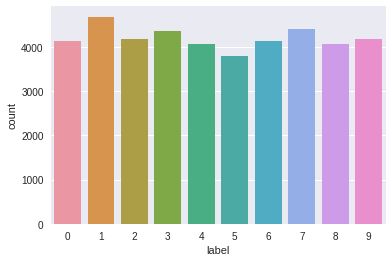

In [4]:
sns.countplot(train['label'])

In [5]:
#loading the dataset.......(Test)
test= pd.read_csv("../input/digit-recognizer/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
x_train = (train.ix[:,1:].values).astype('float32') # all pixel values
y_train = train.ix[:,0].values.astype('int32') # only labels i.e targets digits
x_test = test.values.astype('float32')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-depr

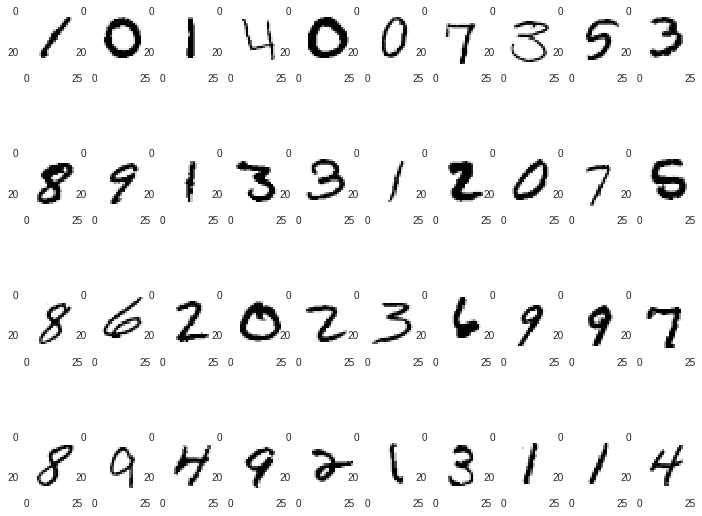

In [7]:
%matplotlib inline
# preview the images first
plt.figure(figsize=(12,10))
x, y = 10, 4
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape((28,28)),interpolation='nearest')
    ax = plt.gca()
    ax.grid(False)
plt.show()

## Normalising The Data 

In [8]:
x_train = x_train/255.0
x_test = x_test/255.0

## Printing the shape of the Datasets

In [9]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (42000, 784)
42000 train samples
28000 test samples


>  ## Reshape To Match The Keras's Expectations

In [10]:
X_train = x_train.reshape(x_train.shape[0], 28, 28,1)
X_test = x_test.reshape(x_test.shape[0], 28, 28,1)

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
batch_size = 64
num_classes = 10
epochs = 20
input_shape = (28, 28, 1)

In [12]:
# convert class vectors to binary class matrices One Hot Encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

**Linear Model**

In [13]:
K.clear_session()
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(ArcMarginProduct(num_classes)) #Use ArcMarginProduct as Final Layer output --> logits (Not probabilities)

model.compile(loss=ArcFaceLoss(n_classes=10),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)         

In [15]:
datagen.fit(X_train)
h = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction],)

Epoch 1/20
590/590 [==============================] - 73s 124ms/step - loss: 1.8985 - accuracy: 0.8173 - val_loss: 0.3756 - val_accuracy: 0.9433
Epoch 2/20
590/590 [==============================] - 72s 122ms/step - loss: 0.5732 - accuracy: 0.9301 - val_loss: 0.2084 - val_accuracy: 0.9660
Epoch 3/20
590/590 [==============================] - 72s 122ms/step - loss: 0.4358 - accuracy: 0.9455 - val_loss: 0.1689 - val_accuracy: 0.9779
Epoch 4/20
590/590 [==============================] - 72s 122ms/step - loss: 0.3715 - accuracy: 0.9546 - val_loss: 0.1295 - val_accuracy: 0.9802
Epoch 5/20
590/590 [==============================] - 73s 123ms/step - loss: 0.2949 - accuracy: 0.9652 - val_loss: 0.1291 - val_accuracy: 0.9826
Epoch 6/20
590/590 [==============================] - 72s 123ms/step - loss: 0.2660 - accuracy: 0.9666 - val_loss: 0.1545 - val_accuracy: 0.9698
Epoch 7/20
590/590 [==============================] - 72s 122ms/step - loss: 0.2626 - accuracy: 0.9676 - val_loss: 0.1305 - val_ac

## Basic Simple Plot And Evaluation

In [16]:
final_loss, final_acc = model.evaluate(X_val, Y_val, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.047943, final accuracy: 0.992857


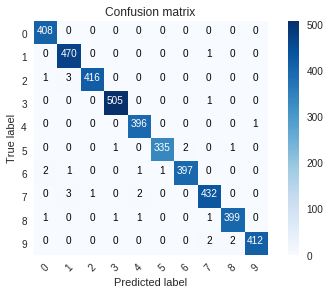

In [17]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    ax = plt.gca()
    ax.grid(False)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


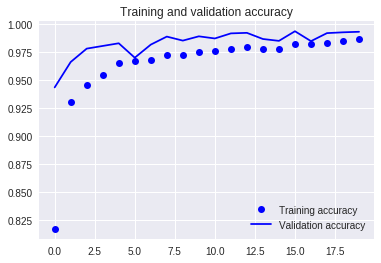

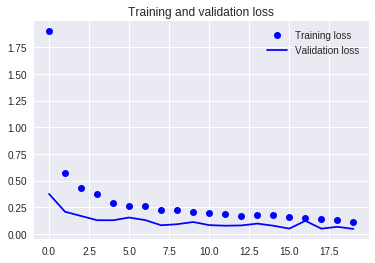

In [18]:
print(h.history.keys())
accuracy = h.history['accuracy']
val_accuracy = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

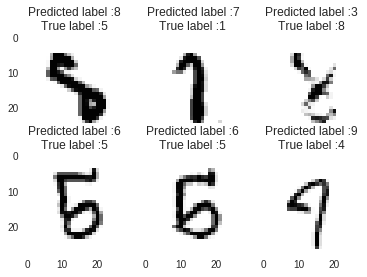

In [19]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            ax[row,col].grid(False)

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## Activations Look Like What?

It looks like diversity of the similar patterns present on multiple classes effect the performance of the classifier although CNN is a robust architechture.

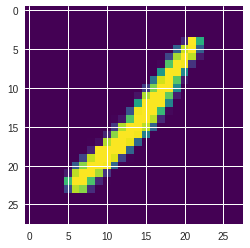

In [20]:
test_im = X_train[154]
plt.imshow(test_im.reshape(28,28), cmap='viridis', interpolation='none')

**Let's see the activation of the 2nd channel of the first layer:**

**Had taken help from the keras [docs](https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer), this [answer](https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer) on  StackOverFlow**

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until


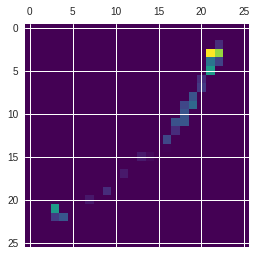

In [21]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(input=model.input, output=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,28,28,1))

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

**Let's plot the activations of the other conv layers as well.**

In [22]:
model.layers[:-1]# Droping The Last Dense Layer

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


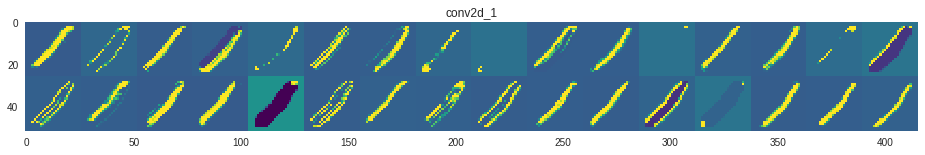

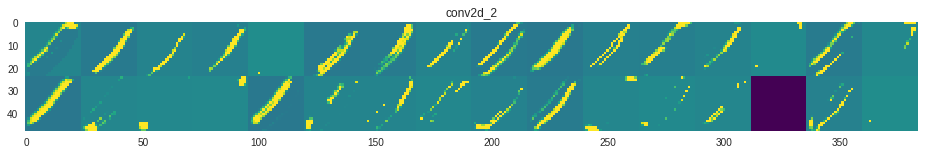

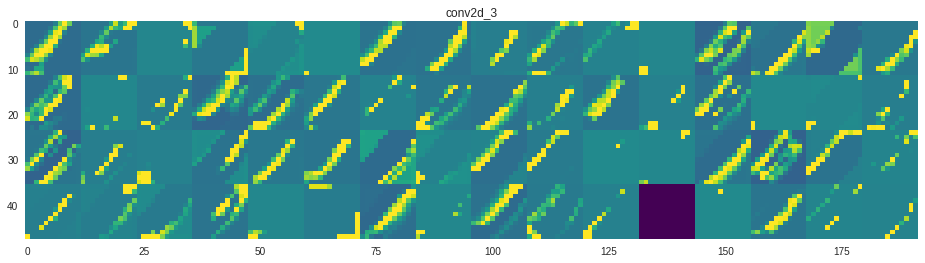

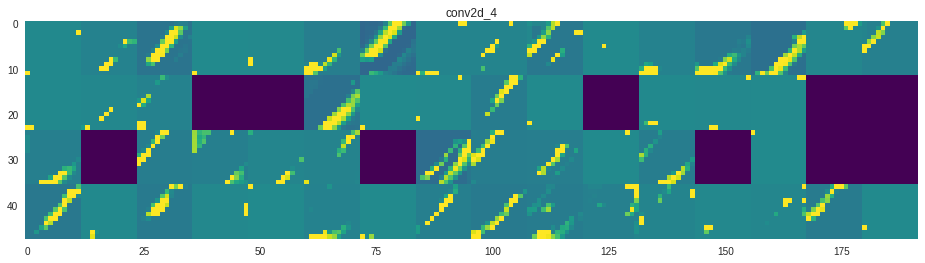

In [23]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


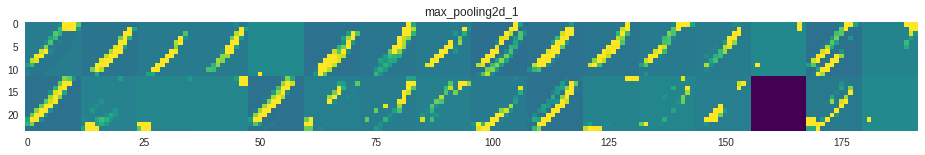

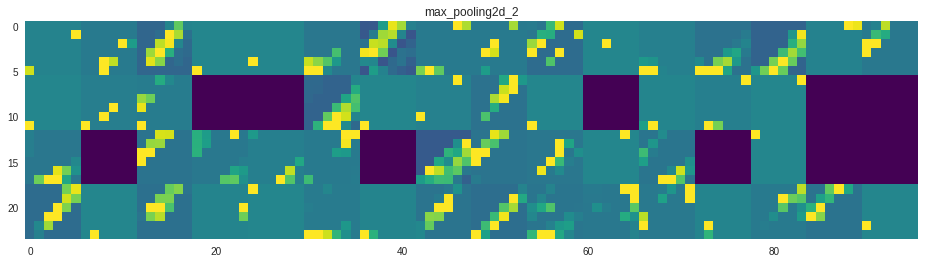

In [24]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('max'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


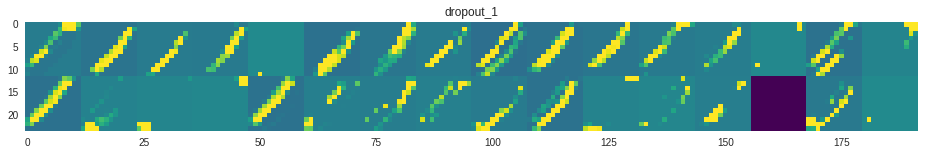

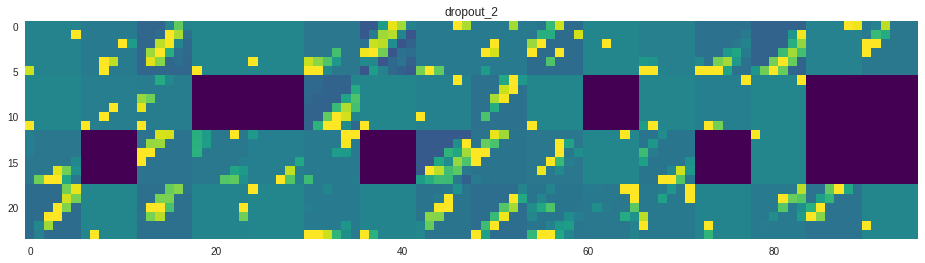

In [25]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('drop'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Classifcation Report

In [26]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true_classes = np.argmax(Y_val, axis = 1)

In [27]:
Y_pred_classes[:5], Y_true_classes[:5]

(array([8, 1, 9, 9, 8]), array([8, 1, 9, 9, 8]))

In [28]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(Y_true_classes, Y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.99      1.00      1.00       408
     Class 1       0.99      1.00      0.99       471
     Class 2       1.00      0.99      0.99       420
     Class 3       1.00      1.00      1.00       506
     Class 4       0.99      1.00      0.99       397
     Class 5       1.00      0.99      0.99       339
     Class 6       0.99      0.99      0.99       402
     Class 7       0.99      0.99      0.99       438
     Class 8       0.99      0.99      0.99       403
     Class 9       1.00      0.99      0.99       416

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



In [29]:
predicted_classes = model.predict_classes(X_test)
submissions=pd.DataFrame({"ImageId": list(range(1,len(predicted_classes)+1)),
                         "Label": predicted_classes})
submissions.to_csv("asd.csv", index=False, header=True)